# Pre-process

In [ ]:
!mkdir /proj

In [ ]:
!mkdir /proj/bird

In [ ]:
!kaggle datasets download -d gpiosenka/100-bird-species

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
License(s): CC0-1.0
100% 1.96G/1.96G [01:49<00:00, 21.4MB/s]
100% 1.96G/1.96G [01:49<00:00, 19.2MB/s]


In [ ]:
!mkdir /temp

In [ ]:
!unzip /content/100-bird-species.zip -d /temp

Streaming output truncated to the last 5000 lines.
  inflating: /temp/train/WHITE TAILED TROPIC/120.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/121.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/122.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/123.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/124.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/125.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/126.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/127.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/128.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/129.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/130.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/131.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/132.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/133.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/134.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/135.jpg  
  inflating: /temp/train/WHITE TAILED TROPIC/136.jpg  
  inflating: /

In [ ]:
!cp -r /temp/train /proj/bird
#!cp -r /temp/valid /proj/bird
#!cp -r /temp/test /proj/bird

In [ ]:
!mkdir /proj/bird/split

In [ ]:
import os
import random
import shutil
from tqdm import tqdm  # To show progress

seed = 42
random.seed(seed)

# Set the paths
original_dataset_dir = '/proj/bird/train'
base_dir = '/proj/bird/split'

# Create directories for split data
train_dir = os.path.join(base_dir, 'train')
os.makedirs(train_dir, exist_ok=True)
val_dir = os.path.join(base_dir, 'validation')
os.makedirs(val_dir, exist_ok=True)
test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok=True)

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Loop through each class directory
for class_folder in tqdm(os.listdir(original_dataset_dir)):
    class_folder_path = os.path.join(original_dataset_dir, class_folder)
    if not os.path.isdir(class_folder_path):
        continue

    # Create subdirectories for each class in train, val, and test directories
    os.makedirs(os.path.join(train_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_folder), exist_ok=True)

    # List all images in the current class folder
    images = os.listdir(class_folder_path)
    random.shuffle(images)

    # Split the images
    total_images = len(images)
    train_count = int(train_ratio * total_images)
    val_count = int(val_ratio * total_images)
    test_count = total_images - train_count - val_count

    # Move images to the respective directories
    for i, image in enumerate(images):
        src = os.path.join(class_folder_path, image)
        if i < train_count:
            dst = os.path.join(train_dir, class_folder, image)
        elif i < train_count + val_count:
            dst = os.path.join(val_dir, class_folder, image)
        else:
            dst = os.path.join(test_dir, class_folder, image)
        shutil.copyfile(src, dst)


100%|██████████| 525/525 [00:17<00:00, 29.54it/s]


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_dir = '/proj/bird/split/train'
val_dir = '/proj/bird/split/validation'
test_dir = '/proj/bird/split/test'

# Data normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

target_size = (224, 224)

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True
)

Found 59016 images belonging to 525 classes.
Found 12455 images belonging to 525 classes.
Found 13164 images belonging to 525 classes.


# View of Images

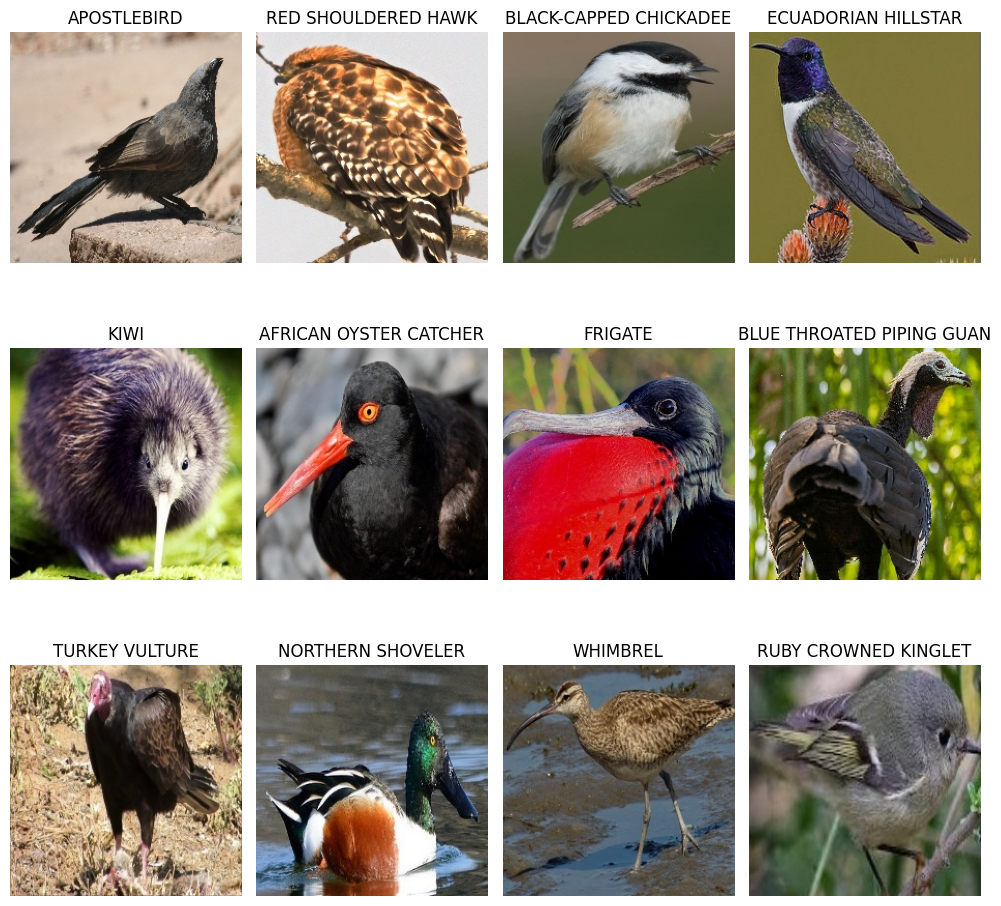

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images, labels = next(train_data)

num_images_to_show = 12
rows = 3
split = int(num_images_to_show/rows)
plt.figure(figsize=(10, 10))

# Map prediction to class name
class_labels = {v: k for k, v in train_data.class_indices.items()}


for i in range(num_images_to_show):
    plt.subplot(rows, split, i + 1)
    plt.imshow(images[i])
    plt.axis('off')
    class_name = class_labels[np.argmax(labels[i])]
    plt.title(class_name)

# Show the images
plt.tight_layout()
plt.show()


To train a DL model for classifying between 525 different species of birds, we will
1. build a simple CNN model
2. Use Transfer learning using ResNet, VGG and Inception

We will check which model performs best

# Simple CNN

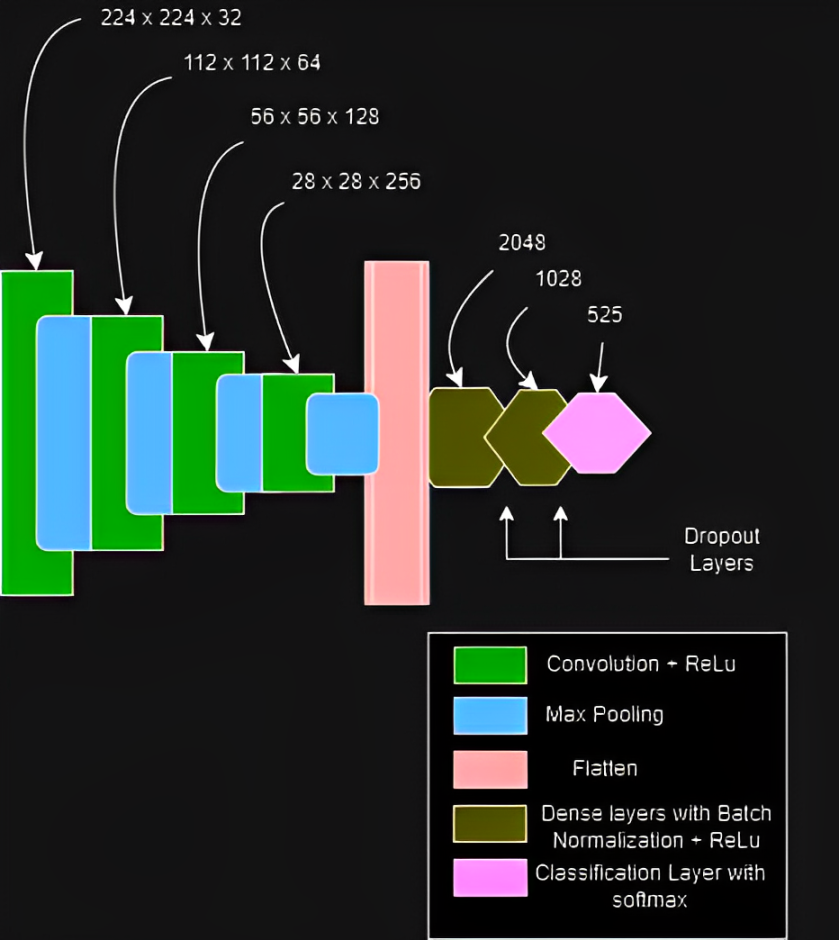

58 mins

In [ ]:
import tensorflow as tf
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(tf.keras.layers.MaxPooling2D((2,2)))

model.add(tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))

model.add(tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))

model.add(tf.keras.layers.Conv2D(256, (3,3), padding='same', activation='relu'))
model.add(tf.keras.layers.MaxPooling2D((2,2)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(2048, activation=None))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(1024, activation=None))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation("relu"))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(525, activation="softmax"))


model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2048)                │     102,762,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 525)                 │         538,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 105,799,501 (403.59 MB)

 Trainable params: 105,793,357 (403.57 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [ ]:
model.compile(optimizer='SGD',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# train model
history = model.fit(train_data, validation_data = val_data, epochs=15, batch_size = 32)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1845/1845 ━━━━━━━━━━━━━━━━━━━━ 192s 98ms/step - accuracy: 0.0159 - loss: 6.2301 - val_accuracy: 0.0774 - val_loss: 5.2065
Epoch 2/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 169s 91ms/step - accuracy: 0.1117 - loss: 4.7929 - val_accuracy: 0.2401 - val_loss: 3.9437
Epoch 3/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 174s 94ms/step - accuracy: 0.2237 - loss: 3.9399 - val_accuracy: 0.3408 - val_loss: 3.3154
Epoch 4/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 159s 86ms/step - accuracy: 0.3331 - loss: 3.2580 - val_accuracy: 0.4004 - val_loss: 2.9063
Epoch 5/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 217s 94ms/step - accuracy: 0.4307 - loss: 2.7369 - val_accuracy: 0.4629 - val_loss: 2.5701
Epoch 6/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 157s 85ms/step - accuracy: 0.5181 - loss: 2.2819 - val_accuracy: 0.5110 - val_loss: 2.3431
Epoch 7/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 208s 88ms/step - accuracy: 0.5997 - loss: 1.8795 - val_accuracy: 0.5384 - val_loss: 2.1490
Epoch 8/15
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 156s 84ms/step - accuracy: 0.6810 - lo

In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

412/412 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - accuracy: 0.6201 - loss: 1.7010
Test loss: 1.6951086521148682
Test accuracy: 0.6210118532180786


In [ ]:
model.save('/content/birdClassificationModelCNNMain.h5')

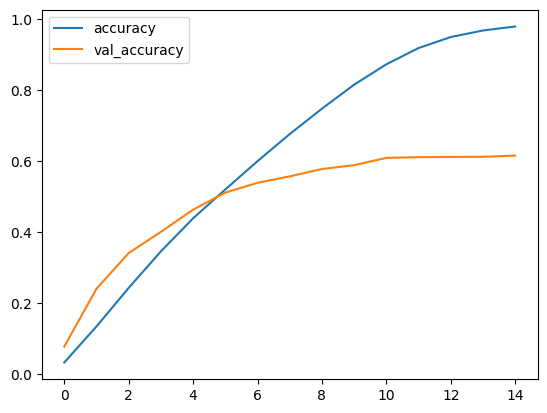

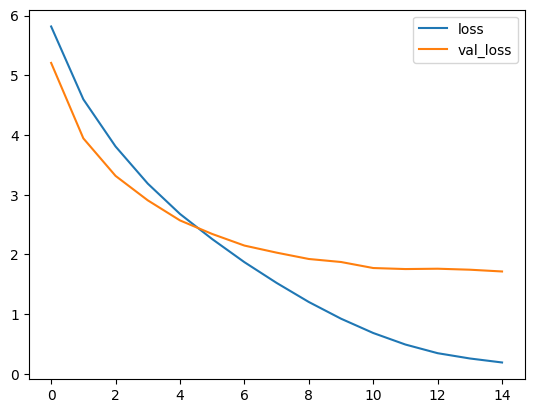

In [ ]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label ="accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label ="loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

### result

Model Conclusion:

Training accuracy increases without any hitch reaching close to 98%, same for the decline in training loss.

However the validation accuracy becomes stagnant around 61% showing overfitting of the model towards training data. This is confirmed with test accuracy of 62.1%

Therefore current defined model is not good enough for unseen data

Computation:

Model took 58 mins for training using on average 4.1 GB GPU ram and close to 12 GB system ram

#ResNet

ResNet 50

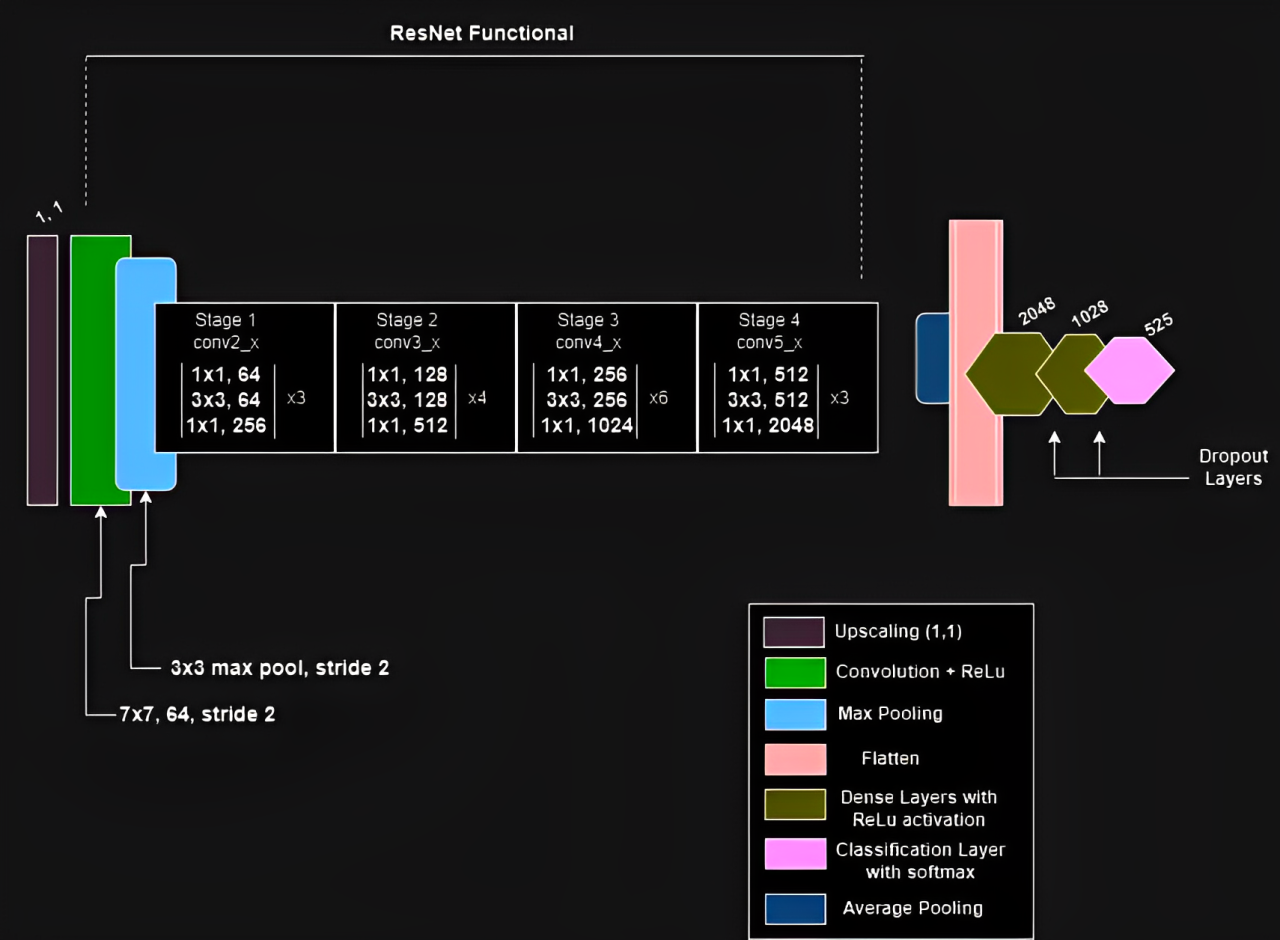

## 1

We are attaching to the top of the base model layers:

1. Average Pooling
2. Flatten
3. Dense layers:

    2048 neurons with ReLu activation

    1024 neurons with ReLu activation

    and classification layer
    525 with softmax activation


In [ ]:
from keras.applications import ResNet50
import tensorflow as tf
# Load pre-trained model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)

    feature_extractor.trainable = False
    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048, activation="relu")(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(525, activation="softmax")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(1,1))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
model = define_compile_model()

In [ ]:
# train model
history = model.fit(train_data, validation_data = val_data, epochs=4, batch_size = 16)

Epoch 1/4


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1845/1845 ━━━━━━━━━━━━━━━━━━━━ 620s 314ms/step - accuracy: 0.2251 - loss: 4.5219 - val_accuracy: 0.7636 - val_loss: 0.9461
Epoch 2/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 570s 299ms/step - accuracy: 0.8586 - loss: 0.5777 - val_accuracy: 0.8437 - val_loss: 0.6092
Epoch 3/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 554s 300ms/step - accuracy: 0.9490 - loss: 0.2107 - val_accuracy: 0.9004 - val_loss: 0.3982
Epoch 4/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 552s 299ms/step - accuracy: 0.9791 - loss: 0.0947 - val_accuracy: 0.9106 - val_loss: 0.3550


In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

412/412 ━━━━━━━━━━━━━━━━━━━━ 45s 109ms/step - accuracy: 0.9115 - loss: 0.3493
Test loss: 0.34961238503456116
Test accuracy: 0.9111212491989136


In [ ]:
model.save('/content/birdModelResnet1.h5')

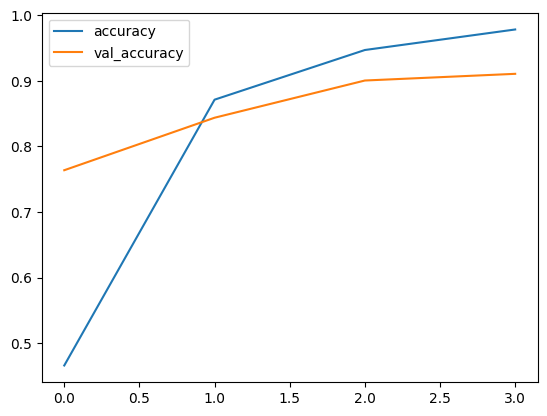

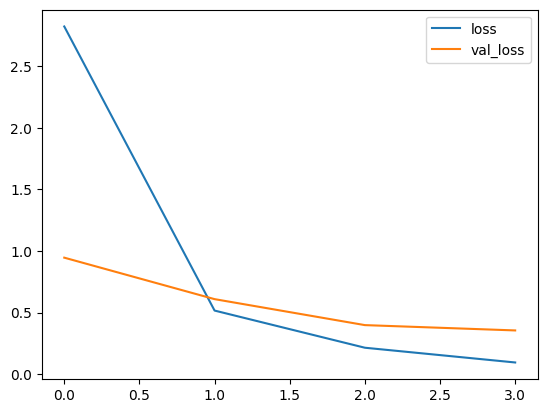

In [ ]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label ="accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label ="loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

## 2

changing the classifier layers in this iteration we are adding an addition dense layer with 4096 neurons before the layer with 2048 layers


In [ ]:
from keras.applications import ResNet50
import tensorflow as tf
# Load pre-trained model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)

    feature_extractor.trainable = False
    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation="relu")(x)
    x = tf.keras.layers.Dense(2048, activation="relu")(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dense(525, activation="softmax")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(1,1))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
model = define_compile_model()

In [ ]:
# train model
history = model.fit(train_data, validation_data = val_data, epochs=4, batch_size = 16)

Epoch 1/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 606s 313ms/step - accuracy: 0.1774 - loss: 4.7991 - val_accuracy: 0.7462 - val_loss: 0.9672
Epoch 2/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 583s 300ms/step - accuracy: 0.8393 - loss: 0.6323 - val_accuracy: 0.8459 - val_loss: 0.5968
Epoch 3/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 553s 300ms/step - accuracy: 0.9397 - loss: 0.2351 - val_accuracy: 0.8752 - val_loss: 0.4940
Epoch 4/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 552s 299ms/step - accuracy: 0.9739 - loss: 0.1050 - val_accuracy: 0.8821 - val_loss: 0.4799


In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

412/412 ━━━━━━━━━━━━━━━━━━━━ 41s 100ms/step - accuracy: 0.8825 - loss: 0.4732
Test loss: 0.4735618531703949
Test accuracy: 0.8827103972434998


In [ ]:
model.save('/content/birdModelResnet2.h5')

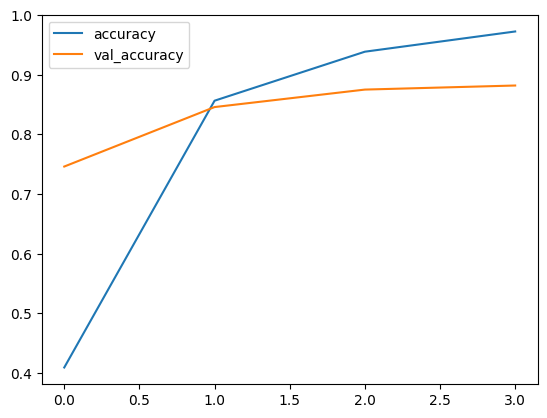

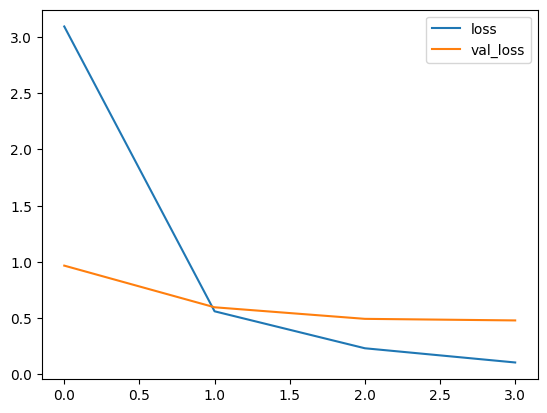

In [ ]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label ="accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label ="loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

## 3

Adding dropout layers to see if we can increase the accuracy

In [ ]:
from keras.applications import ResNet50
import tensorflow as tf
# Load pre-trained model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)

    feature_extractor.trainable = False
    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4096, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(2048, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(525, activation="softmax")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(1,1))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
model = define_compile_model()

In [ ]:
# train model
history = model.fit(train_data, validation_data = val_data, epochs=4, batch_size = 16)

Epoch 1/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 614s 315ms/step - accuracy: 0.0398 - loss: 5.8014 - val_accuracy: 0.6076 - val_loss: 1.7282
Epoch 2/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 578s 302ms/step - accuracy: 0.5391 - loss: 1.8630 - val_accuracy: 0.8180 - val_loss: 0.7321
Epoch 3/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 562s 302ms/step - accuracy: 0.8000 - loss: 0.7415 - val_accuracy: 0.8354 - val_loss: 0.6515
Epoch 4/4
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 558s 302ms/step - accuracy: 0.8889 - loss: 0.4090 - val_accuracy: 0.8886 - val_loss: 0.4388


In [ ]:
# train model
history2 = model.fit(train_data, validation_data = val_data, epochs=3, batch_size = 16)

Epoch 1/3
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 582s 315ms/step - accuracy: 0.9287 - loss: 0.2545 - val_accuracy: 0.8932 - val_loss: 0.4343
Epoch 2/3
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 598s 302ms/step - accuracy: 0.9513 - loss: 0.1701 - val_accuracy: 0.8801 - val_loss: 0.5080
Epoch 3/3
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 563s 303ms/step - accuracy: 0.9663 - loss: 0.1178 - val_accuracy: 0.9064 - val_loss: 0.4080


In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

412/412 ━━━━━━━━━━━━━━━━━━━━ 46s 111ms/step - accuracy: 0.8996 - loss: 0.3959
Test loss: 0.3915506601333618
Test accuracy: 0.9040564894676208


In [ ]:
model.save('/content/birdModelResnet3.h5')

### result

Accuracy:

Model 1

    Training: 97.91
    
    Test: 91.11

Model 2

    Training: 97.39
    
    Test: 88.27

Model 3
   
    Training: 96.63
    
    Test: 90.40

Hence model 1 is the best performing one using ResNet

Computation:

Model1 took 38 mins for training using on average 13.2 GB GPU ram and close to 12 GB system ram

# VGG

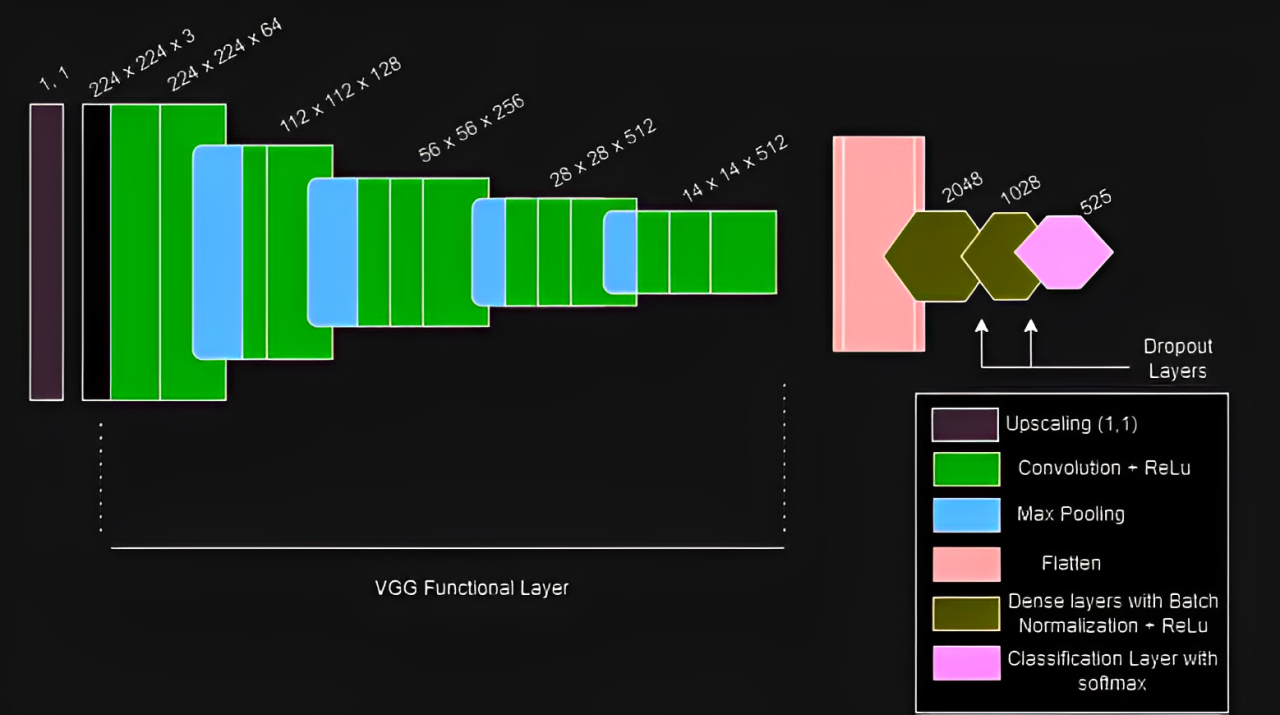

## 1.1

In [ ]:
from keras.applications import VGG16
import tensorflow as tf
# Load pre-trained model without top layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.VGG16(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)

    feature_extractor.trainable = False
    return feature_extractor



def classifier(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(2048, activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(525, activation="softmax")(x)
    return x

def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(1,1))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
model = define_compile_model()

In [ ]:
# train model
history = model.fit(train_data, validation_data = val_data, epochs=5, batch_size = 32)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1845/1845 ━━━━━━━━━━━━━━━━━━━━ 1012s 528ms/step - accuracy: 0.0118 - loss: 6.1646 - val_accuracy: 0.0510 - val_loss: 5.2223
Epoch 2/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 942s 510ms/step - accuracy: 0.1081 - loss: 4.6682 - val_accuracy: 0.3153 - val_loss: 3.3719
Epoch 3/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 941s 510ms/step - accuracy: 0.3806 - loss: 3.0449 - val_accuracy: 0.6185 - val_loss: 1.9904
Epoch 4/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 981s 509ms/step - accuracy: 0.6254 - loss: 1.8573 - val_accuracy: 0.7196 - val_loss: 1.3758
Epoch 5/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 982s 509ms/step - accuracy: 0.7541 - loss: 1.2087 - val_accuracy: 0.7416 - val_loss: 1.1997


In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


412/412 ━━━━━━━━━━━━━━━━━━━━ 61s 149ms/step - accuracy: 0.7408 - loss: 1.2018
Test loss: 1.1876503229141235
Test accuracy: 0.7434670329093933


In [ ]:
model.save('/content/birdClassificationModelVGG1-1.h5')

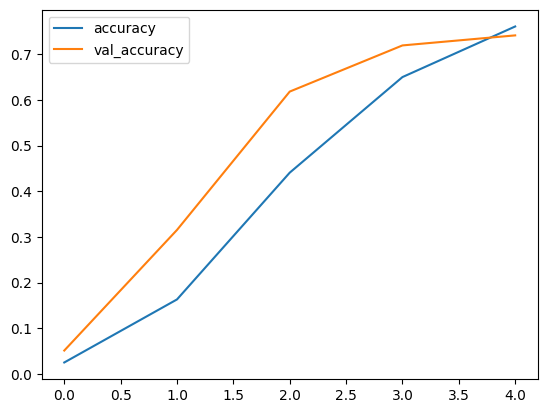

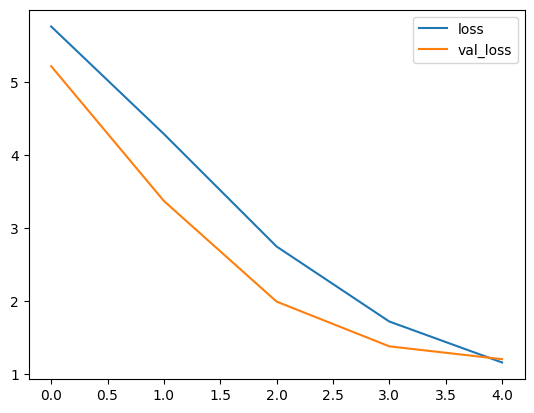

In [ ]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label ="accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label ="loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

## 1.2

further training

In [ ]:
# train model
history2 = model.fit(train_data, validation_data = val_data, epochs=5, batch_size = 32)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1845/1845 ━━━━━━━━━━━━━━━━━━━━ 1070s 558ms/step - accuracy: 0.8012 - loss: 0.9513 - val_accuracy: 0.8544 - val_loss: 0.6857
Epoch 2/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 995s 539ms/step - accuracy: 0.8637 - loss: 0.6639 - val_accuracy: 0.8666 - val_loss: 0.5841
Epoch 3/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 1044s 541ms/step - accuracy: 0.9101 - loss: 0.4599 - val_accuracy: 0.8642 - val_loss: 0.5751
Epoch 4/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 1040s 540ms/step - accuracy: 0.9374 - loss: 0.3287 - val_accuracy: 0.8780 - val_loss: 0.5100
Epoch 5/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 996s 540ms/step - accuracy: 0.9641 - loss: 0.2231 - val_accuracy: 0.9020 - val_loss: 0.4092


In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

412/412 ━━━━━━━━━━━━━━━━━━━━ 68s 164ms/step - accuracy: 0.9073 - loss: 0.3990
Test loss: 0.4051281809806824
Test accuracy: 0.9059556126594543


In [ ]:
model.save('/content/birdClassificationModelVGG_1-2.h5')

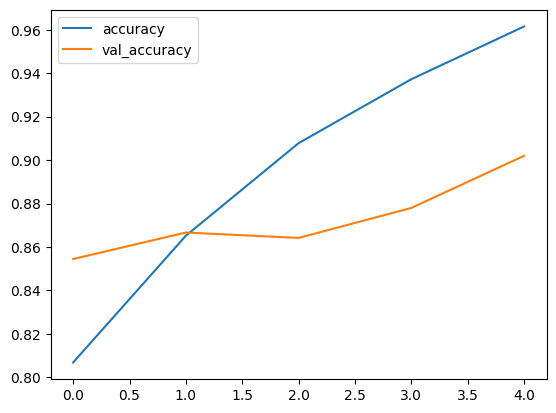

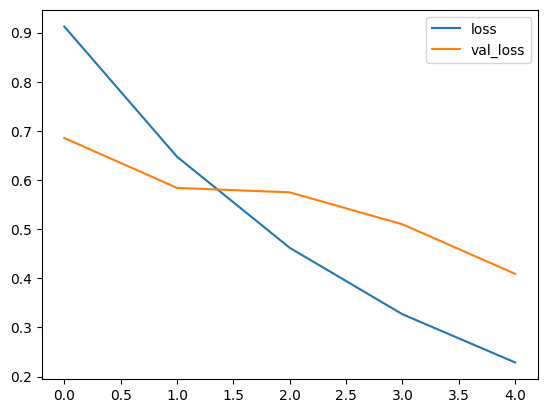

In [ ]:
import matplotlib.pyplot as plt
history = history2
# plot training and validation accuracy
plt.plot(history.history['accuracy'], label ="accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label ="loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

## 1.3

Further training

In [ ]:
history3 = model.fit(train_data, validation_data = val_data, epochs=2, batch_size = 32)

Epoch 1/2
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 998s 541ms/step - accuracy: 0.9795 - loss: 0.1534 - val_accuracy: 0.9013 - val_loss: 0.4121
Epoch 2/2
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 1041s 540ms/step - accuracy: 0.9891 - loss: 0.1066 - val_accuracy: 0.9005 - val_loss: 0.4114


In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

412/412 ━━━━━━━━━━━━━━━━━━━━ 57s 138ms/step - accuracy: 0.9031 - loss: 0.4100
Test loss: 0.4074695110321045
Test accuracy: 0.9038286209106445


In [ ]:
model.save('/content/birdClassificationModelVGG_1-3.h5')

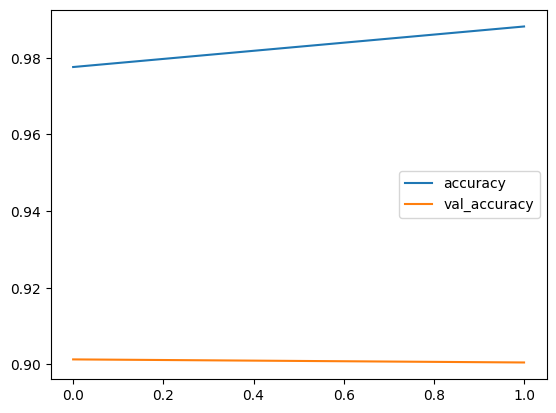

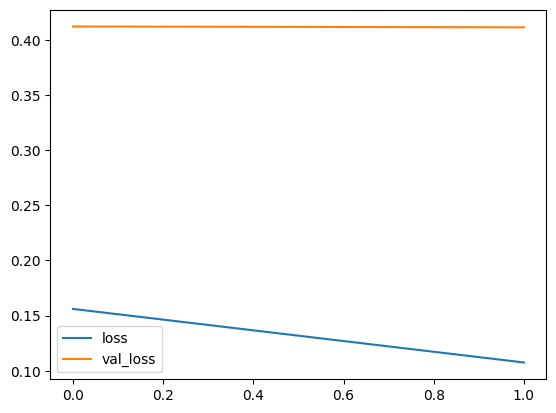

In [ ]:
import matplotlib.pyplot as plt
history = history3
# plot training and validation accuracy
plt.plot(history.history['accuracy'], label ="accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label ="loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

### result


Accuracy:

Model 1.1

    Training: 75.41
    
    Test: 74.34

Model 1.2

    Training: 96.41
    
    Test: 90.5

Model 1.3
   
    Training: 98.91
    
    Test: 90.38

Further training with current model set up is futile as post 90% model has started overfitting to the training data

Henceforth model 1.2 is the best performing one using VGG16

Computation:

Model till step 1.2 took 2hr 40mins for training using on average 8 GB GPU ram and close to 12 GB system ram

# Inception

input size to be 299x299

In [ ]:
import tensorflow as tf
seed = 1
tf.random.set_seed(seed)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_dir = '/proj/bird/split/train'
val_dir = '/proj/bird/split/validation'
test_dir = '/proj/bird/split/test'

# Data normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

target_size = (299, 299)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True,
    seed = seed
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True,
    seed = seed
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True,
    seed = seed
)

Found 59016 images belonging to 525 classes.
Found 12455 images belonging to 525 classes.
Found 13164 images belonging to 525 classes.


In [ ]:
from keras.applications import InceptionV3
import tensorflow as tf
# Load pre-trained model without top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) #dataset size is 32x32 ND 3 is coloured images


In [ ]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_282 (Conv2D)       │ (None, 149, 149, 32)   │            864 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_282   │ (None, 149, 149, 32)   │             96 │ conv2d_282[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_282            │ (None, 149, 149, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_283 (Conv2D)       │ (None, 147, 147, 32)   │          9,216 │ activation_282[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_283   │ (None, 147, 147, 32)   │             96 │ conv2d_283[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_283            │ (None, 147, 147, 32)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_284 (Conv2D)       │ (None, 147, 147, 64)   │         18,432 │ activation_283[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_284   │ (None, 147, 147, 64)   │            192 │ conv2d_284[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_284            │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_12          │ (None, 73, 73, 64)     │              0 │ activation_284[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_285 (Conv2D)       │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d_12[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_285   │ (None, 73, 73, 80)     │            240 │ conv2d_285[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_285            │ (None, 73, 73, 80)     │              0 │ batch_normalization_2… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_286 (Conv2D)  

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))(inputs)

    feature_extractor.trainable = False
    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Dense(2048, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(525, activation="softmax")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(1,1))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(299,299,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
model = define_compile_model()

In [ ]:
# train model
history = model.fit(train_data, validation_data = val_data, epochs=5, batch_size = 32)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1845/1845 ━━━━━━━━━━━━━━━━━━━━ 965s 481ms/step - accuracy: 0.0482 - loss: 5.8009 - val_accuracy: 0.6197 - val_loss: 1.8735
Epoch 2/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 815s 441ms/step - accuracy: 0.5344 - loss: 1.9673 - val_accuracy: 0.8591 - val_loss: 0.5950
Epoch 3/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 894s 458ms/step - accuracy: 0.8203 - loss: 0.7192 - val_accuracy: 0.9043 - val_loss: 0.3884
Epoch 4/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 814s 441ms/step - accuracy: 0.9027 - loss: 0.3910 - val_accuracy: 0.9152 - val_loss: 0.3385
Epoch 5/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 865s 443ms/step - accuracy: 0.9414 - loss: 0.2390 - val_accuracy: 0.9294 - val_loss: 0.2919


In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


412/412 ━━━━━━━━━━━━━━━━━━━━ 63s 153ms/step - accuracy: 0.9288 - loss: 0.2766
Test loss: 0.2937363088130951
Test accuracy: 0.9251747131347656


In [ ]:
model.save('/content/birdClassificationModelInceptionV3-1.h5')

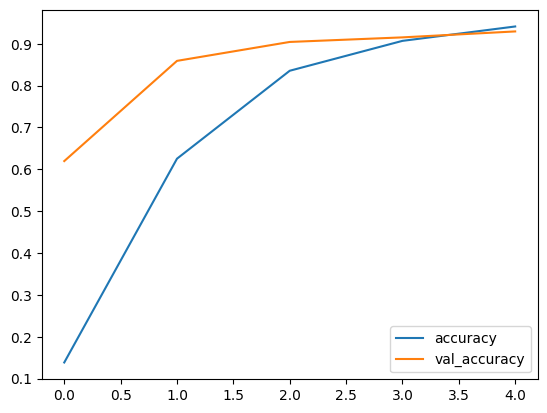

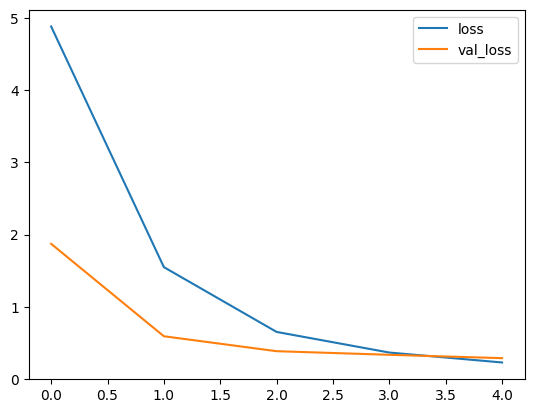

In [ ]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label ="accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label ="loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

### result

Model performs extremely well with limited training

Accuracy:

    Training: 94.14
    Test: 92.51

Computation:

Model took 1hr 5 for training using on average 13.4 GB GPU ram and close to 5.3 GB system ram

# Further increasing Accuracy

Test accuracy

ResNet50

    Test accuracy: 91.11

VGG16

    Test accuracy: 90.5

InceptionV3

    Test accuracy: 92.51



Since VGG16 takes lot of compuational time we shall work with only ResNet50 and InceptionV3

## ResNet50

Adding batch normalization and letting it train for longer

In [ ]:
from keras.applications import ResNet50
import tensorflow as tf
# Load pre-trained model without top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.ResNet50(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')(inputs)

    feature_extractor.trainable = False
    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(2048, activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(1024, activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation("relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(525, activation="softmax")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(1,1))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(224,224,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
model = define_compile_model()

In [ ]:
# train model
history = model.fit(train_data, validation_data = val_data, epochs=7, batch_size = 32)

Epoch 1/7
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 572s 309ms/step - accuracy: 0.1889 - loss: 4.9332 - val_accuracy: 0.7790 - val_loss: 1.4261
Epoch 2/7
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 546s 296ms/step - accuracy: 0.7895 - loss: 1.2722 - val_accuracy: 0.8650 - val_loss: 0.6982
Epoch 3/7
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 545s 295ms/step - accuracy: 0.9076 - loss: 0.5529 - val_accuracy: 0.8996 - val_loss: 0.4665
Epoch 4/7
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 553s 300ms/step - accuracy: 0.9501 - loss: 0.3064 - val_accuracy: 0.9120 - val_loss: 0.3942
Epoch 5/7
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 546s 296ms/step - accuracy: 0.9730 - loss: 0.1791 - val_accuracy: 0.9106 - val_loss: 0.3921
Epoch 6/7
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 547s 296ms/step - accuracy: 0.9863 - loss: 0.1084 - val_accuracy: 0.9162 - val_loss: 0.3673
Epoch 7/7
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 563s 297ms/step - accuracy: 0.9922 - loss: 0.0715 - val_accuracy: 0.9196 - val_loss: 0.3344


In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

412/412 ━━━━━━━━━━━━━━━━━━━━ 43s 104ms/step - accuracy: 0.9246 - loss: 0.3288
Test loss: 0.3096926510334015
Test accuracy: 0.9260103106498718


In [ ]:
model.save('/content/birdClassificationModelResNet50.h5')

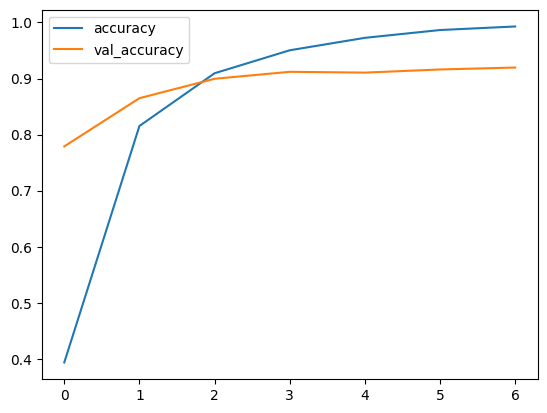

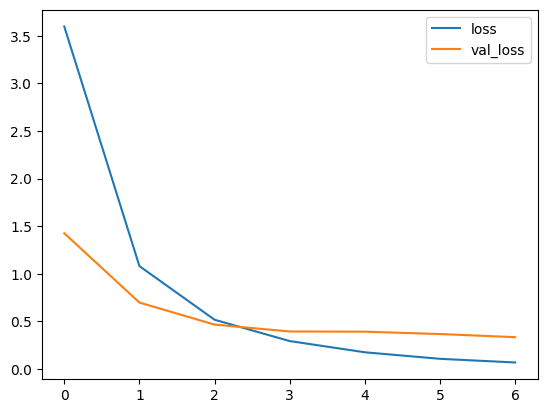

In [ ]:
import matplotlib.pyplot as plt

# plot training and validation accuracy
plt.plot(history.history['accuracy'], label ="accuracy")
plt.plot(history.history['val_accuracy'], label = "val_accuracy")
plt.legend()
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'], label ="loss")
plt.plot(history.history['val_loss'], label = "val_loss")
plt.legend()
plt.show()

Accuracy:

    Training: 99.22
    Test: 92.60

## InceptionV3

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directory paths
train_dir = '/proj/bird/split/train'
val_dir = '/proj/bird/split/validation'
test_dir = '/proj/bird/split/test'

# Data normalization
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

target_size = (299, 299)
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True
)

val_data = val_datagen.flow_from_directory(
    val_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    class_mode='categorical',
    shuffle=True
)

Found 59016 images belonging to 525 classes.
Found 12455 images belonging to 525 classes.
Found 13164 images belonging to 525 classes.


In [ ]:
from keras.applications import InceptionV3
import tensorflow as tf
# Load pre-trained model without top layer
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3)) #dataset size is 32x32 ND 3 is coloured images


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 299, 299, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [ ]:
def feature_extractor(inputs):
    feature_extractor = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))(inputs)

    feature_extractor.trainable = False
    return feature_extractor


def classifier(inputs):
    x = tf.keras.layers.GlobalAveragePooling2D()(inputs)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.Dense(525, activation="softmax")(x)
    return x


def final_model(inputs):
    resize = tf.keras.layers.UpSampling2D(size=(1,1))(inputs)
    resnet_feature_extractor = feature_extractor(resize)
    classification_output = classifier(resnet_feature_extractor)
    return classification_output

In [ ]:
def define_compile_model():
  inputs = tf.keras.layers.Input(shape=(299,299,3))

  classification_output = final_model(inputs)
  model = tf.keras.Model(inputs=inputs, outputs = classification_output)

  model.compile(optimizer='SGD',
                loss='categorical_crossentropy',
                metrics = ['accuracy'])

  return model

In [ ]:
model = define_compile_model()

In [ ]:
# train model 1hr 10 mins
history = model.fit(train_data, validation_data = val_data, epochs=5, batch_size = 32)

Epoch 1/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 891s 456ms/step - accuracy: 0.1239 - loss: 5.3677 - val_accuracy: 0.7259 - val_loss: 1.4708
Epoch 2/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 829s 449ms/step - accuracy: 0.6934 - loss: 1.4615 - val_accuracy: 0.8817 - val_loss: 0.5547
Epoch 3/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 829s 431ms/step - accuracy: 0.8751 - loss: 0.5921 - val_accuracy: 0.9112 - val_loss: 0.3837
Epoch 4/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 795s 430ms/step - accuracy: 0.9302 - loss: 0.3313 - val_accuracy: 0.9236 - val_loss: 0.3088
Epoch 5/5
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 830s 449ms/step - accuracy: 0.9582 - loss: 0.2095 - val_accuracy: 0.9301 - val_loss: 0.2813


In [ ]:
part1=history.history

In [ ]:
# train model 26 mins
history2 = model.fit(train_data, validation_data = val_data, epochs=2, batch_size = 32)

Epoch 1/2
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 796s 431ms/step - accuracy: 0.9759 - loss: 0.1311 - val_accuracy: 0.9342 - val_loss: 0.2639
Epoch 2/2
1845/1845 ━━━━━━━━━━━━━━━━━━━━ 807s 434ms/step - accuracy: 0.9856 - loss: 0.0907 - val_accuracy: 0.9367 - val_loss: 0.2559


In [ ]:
part2=history2.history

In [ ]:
# evaluate model on test data
test_loss, test_acc = model.evaluate(test_data)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


412/412 ━━━━━━━━━━━━━━━━━━━━ 79s 193ms/step - accuracy: 0.9322 - loss: 0.2801
Test loss: 0.2670538127422333
Test accuracy: 0.9341385364532471


In [ ]:
model.save('/content/birdClassificationModelInceptionV3.h5')

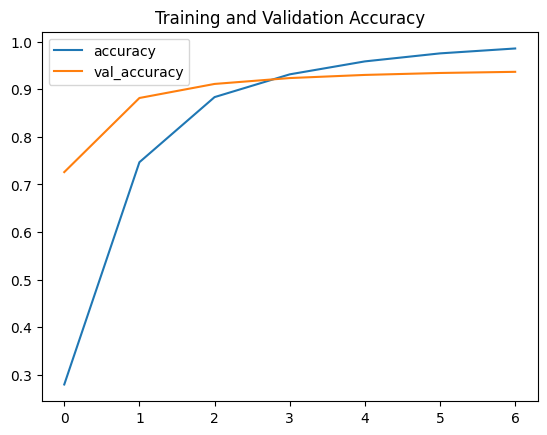

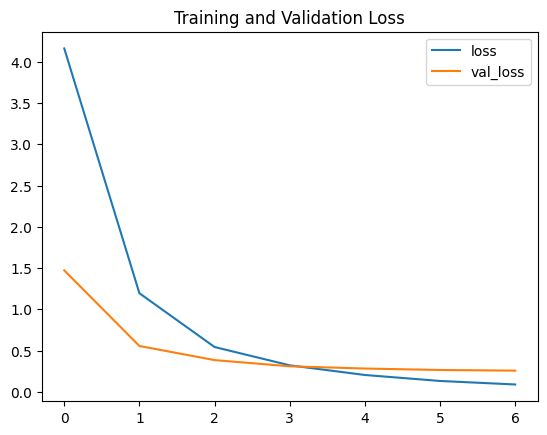

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

accuracy = np.concatenate([part1['accuracy'], part2['accuracy']])
val_accuracy = np.concatenate([part1['val_accuracy'], part2['val_accuracy']])

loss = np.concatenate([part1['loss'], part2['loss']])
val_loss = np.concatenate([part1['val_loss'], part2['val_loss']])


plt.plot(accuracy, label="accuracy")
plt.plot(val_accuracy, label="val_accuracy")
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()

plt.plot(loss, label="loss")
plt.plot(val_loss, label="val_loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


Accuracy:

    Training: 98.56
    Test: 93.41

# Conclusion

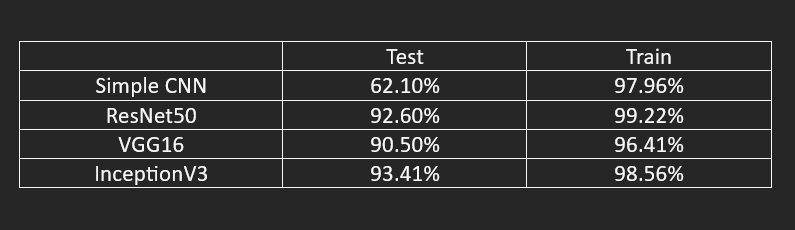

All models trained using Transfer learning are performing well, with InceptionV3 and ResNet50 used as the base model are top performing

## testing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class_labels = {v: k for k, v in train_data.class_indices.items()}

In [ ]:
import pickle
with open('labels.pkl', 'wb') as file:
    pickle.dump(class_labels, file)


In [ ]:
import pickle
with open('/path/to/labels.pkl', 'rb') as file:
    class_labels = pickle.load(file)

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predict(model, img):
  prediction = model.predict(img)
  predicted_class = np.argmax(prediction, axis=1)
  predicted_class_name = class_labels[predicted_class[0]]
  return predicted_class_name

# Load model
model1 = load_model('/path/to/birdClassificationModelCNN.h5')
model2 = load_model('/path/to/birdClassificationModelResNet.h5')
model3 = load_model('/path/to/birdClassificationModelVGG16_1-2.h5')
model4 = load_model('/path/to/birdClassificationModelInceptionV3.h5')

In [ ]:
# Preprocess image
img_path ='/content/p3.webp'# '/stock-photo-beautiful-blue-peakcock-in-natural-scottish-landscape-beautiful-long-tail-and-colours-with-2283331975.jpg'
img_array1 = preprocess_image(img_path, target_size=(224, 224))
img_array2 = preprocess_image(img_path, target_size=(299, 299))

In [ ]:
# Make prediction
prediction1 =  predict(model1, img_array1)
prediction2 =  predict(model2, img_array1)
prediction3 =  predict(model3, img_array1)
prediction4 =  predict(model4, img_array2)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


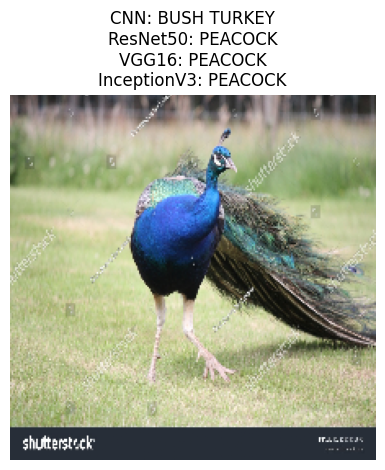

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0

plt.imshow(img_array)
plt.axis('off')

preds = f'''CNN: {prediction1}
ResNet50: {prediction2}
VGG16: {prediction3}
InceptionV3: {prediction4}'''
plt.title(preds)

plt.tight_layout()
plt.show()


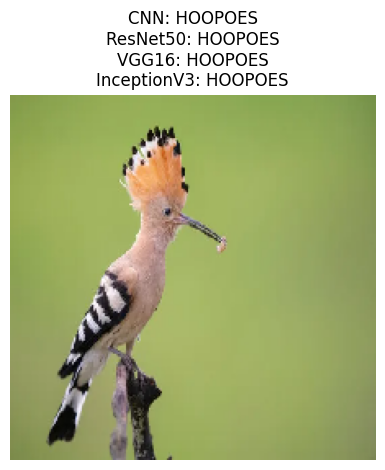

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing import image

img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = img_array / 255.0

plt.imshow(img_array)
plt.axis('off')

preds = f'''CNN: {prediction1}
ResNet50: {prediction2}
VGG16: {prediction3}
InceptionV3: {prediction4}'''
plt.title(preds)

plt.tight_layout()
plt.show()
